In [14]:
import sys
from collections import defaultdict
import os
import pandas as pd
import csv
import random

import shap
shap.initjs()
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score, recall_score
from tqdm.notebook import tqdm
import numpy as np
import xgboost as xgb




SEED = 42
np.random.seed(SEED)
random.seed(SEED)

The next step is most likely required.

The requirement is to append the path to `biological-systems-modelling` repo to `sys.path`.

A conda enviroment is located in `biological-systems-modelling/project/environment.yml`.

In [2]:
sys.path.append('/Users/ant/studia/biological-systems-modelling')
from constants import disease_to_target
from analysis import MicrobialAbundanceAnalysis

# Loading data and hyperparameter search results

A hyperparameter search was done calling `python parameter_search.py hyperparameter_search_results_f1`.
It wasn't done on a fixed random seed, so the results might be slightly different.

The data has to be downloaded from https://www.kaggle.com/antaresnyc/metagenomics. A `SPECIES_ABUNDANCE_FP` variable has to be set to a path to `abundance.txt` file.

In [3]:
SPECIES_ABUNDANCE_FP = '/Volumes/Data/project_cbs/abundance.txt'

In [4]:
analysis = MicrobialAbundanceAnalysis.from_file(SPECIES_ABUNDANCE_FP)

In [5]:
hyperparams_path = 'hyperparameter_search_results_f1/'

In [6]:
params_per_disease = defaultdict(list)
for file in os.listdir(hyperparams_path):
    fname, _, _ = file[len('hparams_'):].partition('.')
    disease, level = fname.rsplit('_', 1)
    with open(os.path.join(hyperparams_path, file)) as handle:
        reader = csv.DictReader(handle, delimiter='\t')
        for record in reader:
            new_record = record.copy()
            new_record['level'] = level
            params_per_disease[disease].append(new_record)

In [7]:
best_params_per_disease = dict()

for disease, params in params_per_disease.items():
    best = sorted(params, reverse=True, key=lambda x: float(x['mean_test_score']))[0]
    param_dict = eval(best['params'])
    param_dict['level'] = best['level']
    best_params_per_disease[disease] = param_dict

In [8]:
best_params_per_disease

{'cirrhosis': {'verbosity': 0,
  'use_label_encoder': False,
  'subsample': 0.9,
  'objective': 'binary:logistic',
  'n_estimators': 147,
  'min_child_weight': 2,
  'max_depth': 14,
  'learning_rate': 0.4804,
  'gamma': 0.23,
  'eta': 0.74,
  'level': 't'},
 't2d': {'verbosity': 0,
  'use_label_encoder': False,
  'subsample': 0.58,
  'objective': 'binary:logistic',
  'n_estimators': 168,
  'min_child_weight': 5,
  'max_depth': 4,
  'learning_rate': 0.0296,
  'gamma': 0.165,
  'eta': 0.6,
  'level': 's'},
 'impaired_glucose_tolerance': {'verbosity': 0,
  'use_label_encoder': False,
  'subsample': 0.75,
  'objective': 'binary:logistic',
  'n_estimators': 204,
  'min_child_weight': 7,
  'max_depth': 4,
  'learning_rate': 0.4314,
  'gamma': 0.47500000000000003,
  'eta': 0.53,
  'level': 't'},
 'colorectal_neoplasm': {'verbosity': 0,
  'use_label_encoder': False,
  'subsample': 0.825,
  'objective': 'binary:logistic',
  'n_estimators': 223,
  'min_child_weight': 11,
  'max_depth': 9,
  'lea

# SHAP plots

In [9]:
def prepare_summary_plot(disease):
    (X_train, y_train), (X_test, y_test), params = analysis.prepare_dataset(
        skip_metadata=True, diseases=[disease], 
        level=best_params_per_disease[disease]['level'], seed=SEED
    )
    X = pd.concat([X_train, X_test])
    readable_colnames = [x.split('|')[-1] for x in X.columns]

    model = analysis.train_classifier(
        (pd.concat([X_train, X_test]), list(y_train) + list(y_test)), 
        (X_test, y_test),
        xgboost_params=best_params_per_disease['ibd'],
        additional_params=params
    )
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, max_display=10, plot_type='violin', plot_size=(15, 10), feature_names=readable_colnames)

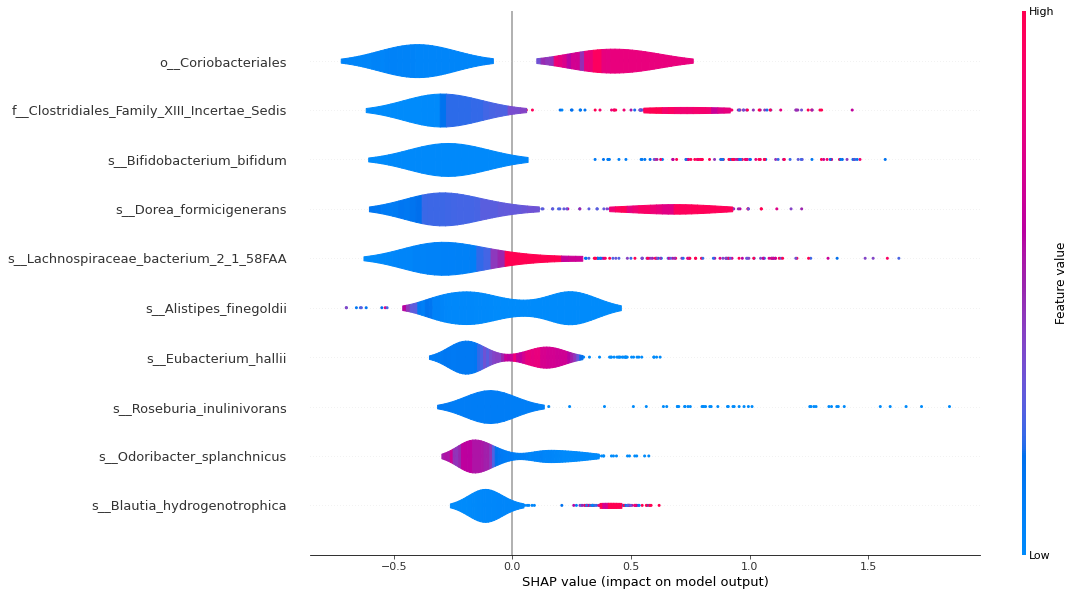

In [10]:
prepare_summary_plot('ibd')

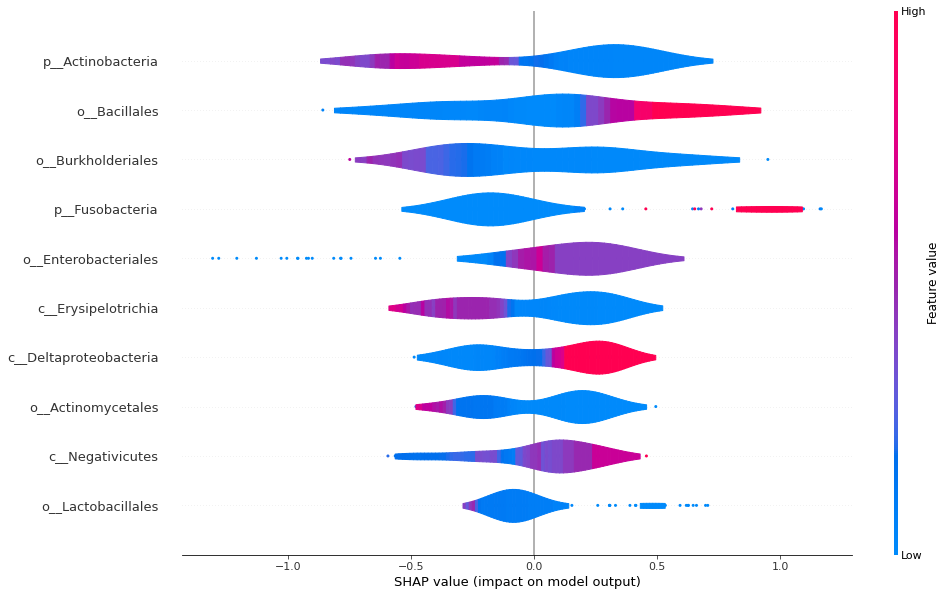

In [11]:
prepare_summary_plot('colorectal_neoplasm')

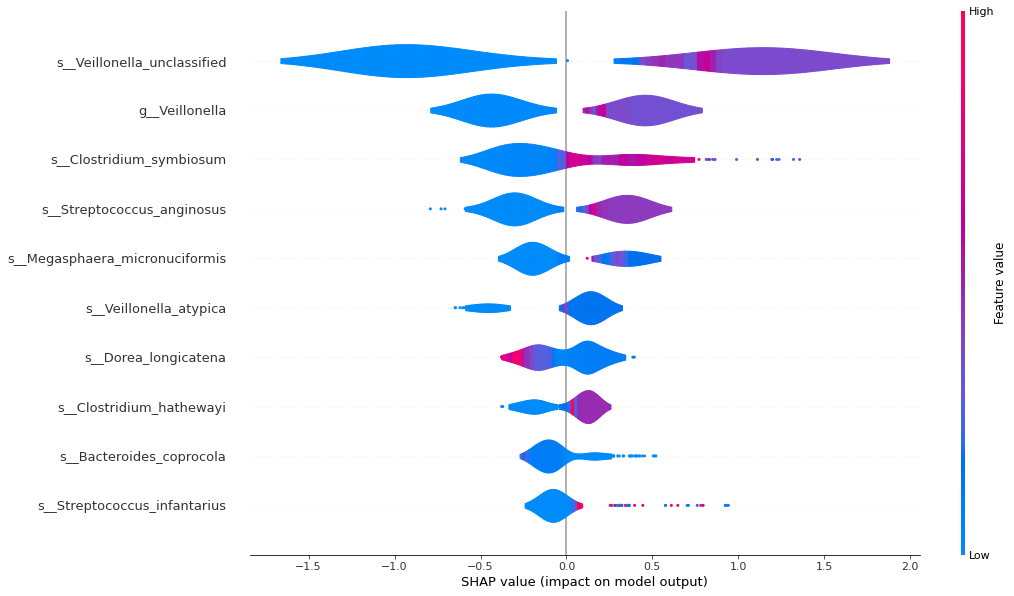

In [12]:
prepare_summary_plot('cirrhosis')

# Computing final metrics

In [15]:
disease_to_cv_results = defaultdict(dict)

for disease in [
    'cirrhosis', 'colorectal_neoplasm', 'ibd',
    'impaired_glucose_tolerance', 'obesity', 't2d'
]:
    best_params = best_params_per_disease[disease]
    
    train_set, test_set, params = analysis.prepare_dataset(
        skip_metadata=True, diseases=[disease], level=best_params['level'], seed=SEED
    )

    X = pd.concat([train_set[0], test_set[0]])
    y = np.array(list(train_set[1]) + list(test_set[1]))
    
    
    
    scores = defaultdict(list)
    
    for train_index, test_index in tqdm(StratifiedKFold(n_splits=10).split(X, y), total=10):
        X_train = X.iloc[list(train_index)]
        y_train = y[train_index]
        model = xgb.XGBClassifier(**best_params)
        model.fit(X_train, y_train)
        pred = model.predict(X.iloc[list(test_index)])
        scores['f1'].append(f1_score(y[test_index], pred))
        scores['accuracy'].append(accuracy_score(y[test_index], pred))
        scores['roc_auc'].append(roc_auc_score(y[test_index], pred))
        scores['precision'].append(precision_score(y[test_index], pred))
        scores['recall'].append(recall_score(y[test_index], pred))
    
        
        
    
    print(disease)
    for k, v in scores.items():
        print(k, np.mean(v), np.std(v))
    print()
    disease_to_cv_results[disease] = scores

  0%|          | 0/10 [00:00<?, ?it/s]

cirrhosis
f1 0.8804724261246 0.06522072101375605
accuracy 0.8838768115942027 0.060402202057893165
roc_auc 0.8848484848484848 0.05939123370460495
precision 0.9085858585858585 0.041290774618120585
recall 0.8568181818181818 0.09074796326896578



  0%|          | 0/10 [00:00<?, ?it/s]

colorectal_neoplasm
f1 0.7799302177011155 0.06110572374637097
accuracy 0.6879120879120879 0.08606577691956604
roc_auc 0.6130555555555557 0.10862709458975851
precision 0.7252272727272727 0.07975948838316461
recall 0.861111111111111 0.11669973076444447



  0%|          | 0/10 [00:00<?, ?it/s]

ibd
f1 0.8853075140124476 0.04085073020201635
accuracy 0.9123232323232324 0.032840091116380775
roc_auc 0.9039993775287893 0.03239891643786639
precision 0.9079575163398694 0.06642553992099386
recall 0.8669934640522875 0.04570609311410391



  0%|          | 0/10 [00:00<?, ?it/s]

impaired_glucose_tolerance
f1 0.5225291375291377 0.23973729499143384
accuracy 0.53 0.15444444444444444
roc_auc 0.5349999999999999 0.14150971698084905
precision 0.503452380952381 0.20733054578479143
recall 0.575 0.31244999599935985



  0%|          | 0/10 [00:00<?, ?it/s]

obesity
f1 0.7108789392108578 0.05722676873827246
accuracy 0.6296296296296297 0.05201289643749508
roc_auc 0.5950924688057041 0.043778606199951664
precision 0.656090420774093 0.03871508828995695
recall 0.7863970588235294 0.11558919416605722



  0%|          | 0/10 [00:00<?, ?it/s]

t2d
f1 0.6831135392846357 0.07054068202293441
accuracy 0.6681818181818181 0.08393720596645177
roc_auc 0.6674242424242423 0.08445799733703627
precision 0.6737899137899138 0.0967420810076774
recall 0.7 0.07560057053600147

